In [1]:
# %% Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import yaml
from tqdm import tqdm

from data.us_dataset import UnifiedUltrasoundDataset
from utils.losses.mse_correlation_loss import MSECorrelationLoss
from utils.reconstruction import reconstruct_volume

In [2]:
# %% Define DCLNet model


class DCLNet(nn.Module):
    def __init__(self, num_input_frames=5, num_classes=6):
        super(DCLNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=(3, 7, 7),
            stride=(1, 2, 2),
            padding=(1, 3, 3),
            bias=False,
        )
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(
            kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)
        )

        self.layer1 = self._make_layer(64, 128, 3)
        self.layer2 = self._make_layer(128, 256, 4)
        self.layer3 = self._make_layer(256, 512, 6)
        self.layer4 = self._make_layer(512, 1024, 3)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(1024, num_classes)

        self.attention = nn.Sequential(
            nn.Conv3d(1024, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(512, 1, kernel_size=1),
            nn.Sigmoid(),
        )

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        )
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, blocks):
            layers.append(
                nn.Conv3d(
                    out_channels, out_channels, kernel_size=3, stride=1, padding=1
                )
            )
            layers.append(nn.BatchNorm3d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        attention = self.attention(x)
        x = x * attention

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [3]:
# %% Load configuration


def load_config(config_path):
    with open(config_path, "r") as f:
        return yaml.safe_load(f)


config = load_config("configs/default_config.yaml")
device = torch.device(config["device"])

In [4]:
# %% Load data

dataset = UnifiedUltrasoundDataset(
    file_paths=config["data_file"],
    sequence_length=config["sequence_length"],
    downsample_factor=config["downsample_factor"],
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])

In [5]:
# %% Define model, loss, and optimizer

model = DCLNet(num_input_frames=config["sequence_length"], num_classes=6).to(device)

# criterion = MSECorrelationLoss(lambda_corr=config["lambda_corr"])
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
# %% Training loop


# %% Training loop
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for frames, _, targets in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"
        ):
            frames, targets = frames.to(device), targets.to(device)
            frames = frames.permute(0, 2, 1, 3, 4)

            outputs = model(frames)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames, _, targets in val_loader:
                frames, targets = frames.to(device), targets.to(device)
                frames = frames.permute(0, 2, 1, 3, 4)
                outputs = model(frames)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

    return model


trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    config["num_epochs"],
)

# Save the trained model
torch.save(trained_model.state_dict(), "trained_dclnet_model.pth")

Epoch 1/3: 100%|██████████| 398/398 [00:16<00:00, 24.07it/s]


Epoch 1, Train Loss: 0.0534, Val Loss: 0.0505


Epoch 2/3: 100%|██████████| 398/398 [00:16<00:00, 24.35it/s]


Epoch 2, Train Loss: 0.0526, Val Loss: 0.0483


Epoch 3/3: 100%|██████████| 398/398 [00:16<00:00, 24.30it/s]


Epoch 3, Train Loss: 0.0543, Val Loss: 0.0501


In [7]:
# %% Prediction


# %% Prediction
def predict(model, data_loader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for frames, _, _ in tqdm(data_loader, desc="Predicting"):
            frames = frames.to(device)
            frames = frames.permute(0, 2, 1, 3, 4)
            outputs = model(frames)
            all_predictions.append(outputs.cpu().numpy())

    return np.concatenate(all_predictions, axis=0)


predictions = predict(trained_model, val_loader)

Predicting: 100%|██████████| 100/100 [00:01<00:00, 86.55it/s]


In [9]:
# %% Reconstruction


def reconstruct_predicted_volume(predictions, val_dataset):
    probe_specs = config["probe_specs"]
    voxel_size = config["reconstruction_voxel_size"]

    # Assuming predictions contain relative transformations
    # You'll need to convert these to absolute positions
    absolute_positions = np.cumsum(predictions, axis=0)

    # Get the corresponding frames from the dataset
    frames = [val_dataset[i][0].numpy() for i in range(len(val_dataset))]

    # Convert list of frames to a numpy array
    frames = np.array(frames)

    # Squeeze out any singleton dimensions if present
    frames = np.squeeze(frames)

    reconstructed_volume, volume_origin, voxel_size = reconstruct_volume(
        frames, absolute_positions, probe_specs, voxel_size=voxel_size
    )

    return reconstructed_volume, volume_origin, voxel_size


reconstructed_volume, volume_origin, voxel_size = reconstruct_predicted_volume(
    predictions, val_dataset
)

Reconstructing volume...


100%|██████████| 100/100 [00:00<00:00, 703.07it/s]


In [10]:
# %% Save results

np.save("reconstructed_volume_dclnet.npy", reconstructed_volume)
print(f"Reconstructed volume shape: {reconstructed_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size}")

Reconstructed volume shape: (615, 651, 761)
Volume origin: [-45.87123408   0.06330955 -21.95226136]
Voxel size: 0.1


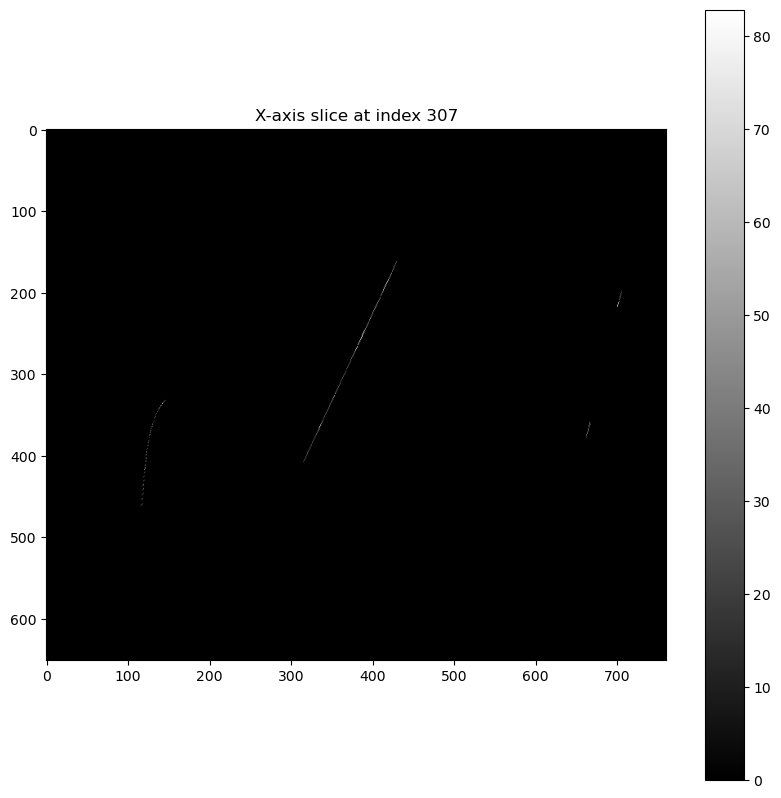

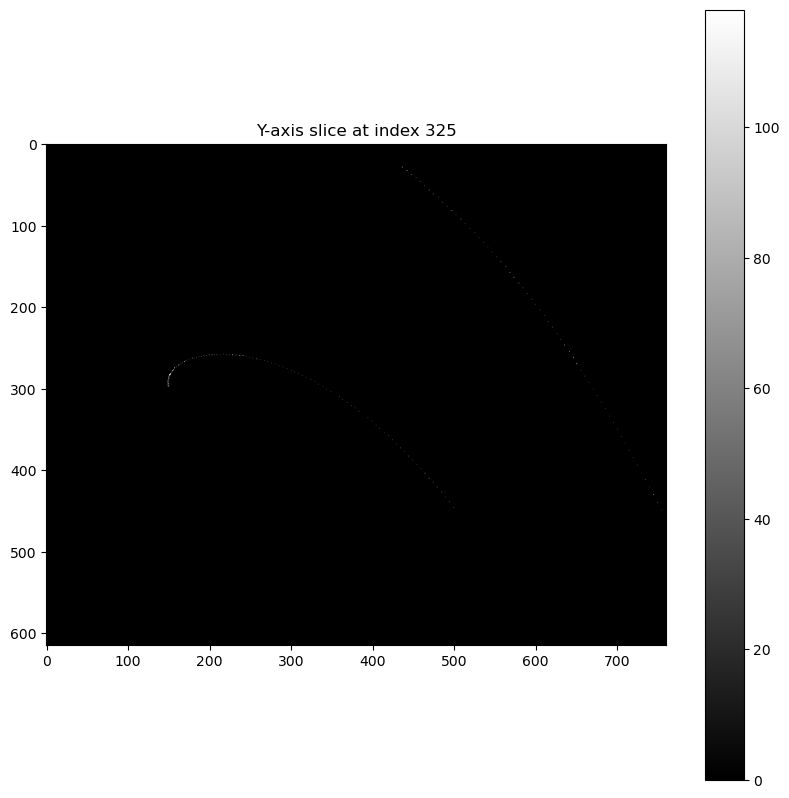

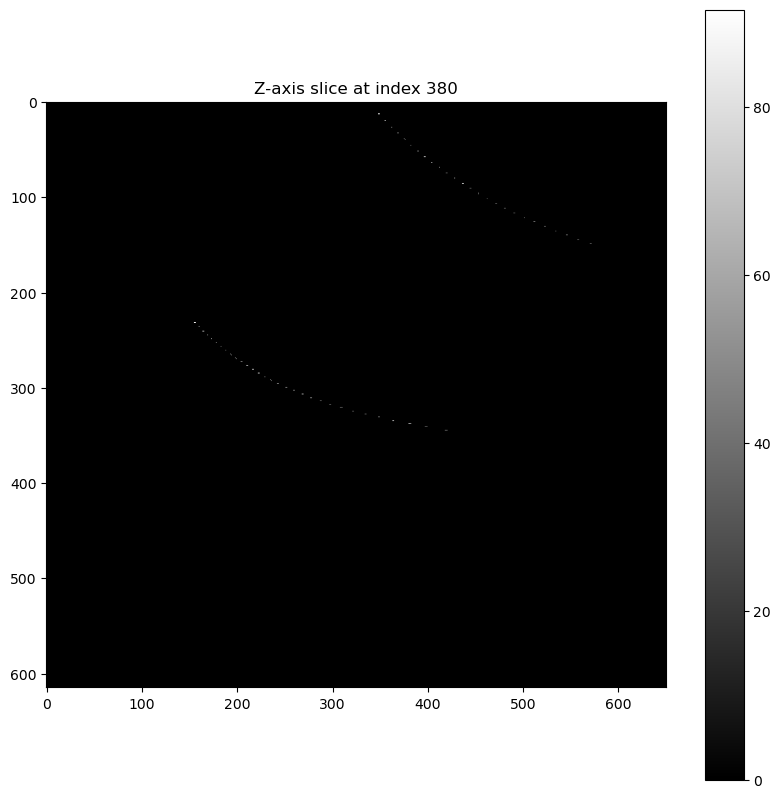

In [11]:
# %% Visualization (optional)

import matplotlib.pyplot as plt


def plot_slice(volume, slice_index, axis):
    plt.figure(figsize=(10, 10))
    if axis == "x":
        plt.imshow(volume[slice_index, :, :], cmap="gray")
    elif axis == "y":
        plt.imshow(volume[:, slice_index, :], cmap="gray")
    elif axis == "z":
        plt.imshow(volume[:, :, slice_index], cmap="gray")
    plt.title(f"{axis.upper()}-axis slice at index {slice_index}")
    plt.colorbar()
    plt.show()


# Plot middle slices along each axis
plot_slice(reconstructed_volume, reconstructed_volume.shape[0] // 2, "x")
plot_slice(reconstructed_volume, reconstructed_volume.shape[1] // 2, "y")
plot_slice(reconstructed_volume, reconstructed_volume.shape[2] // 2, "z")

In [14]:
def plot_trajectories(ground_truth, imu_trajectory, predicted_trajectory):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("Trajectory Comparison", fontsize=16)

    # Subplot 1: Ground Truth Trajectory
    ax1 = fig.add_subplot(131, projection="3d")
    ax1.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2])
    ax1.set_title("Ground Truth Trajectory")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Subplot 2: IMU Trajectory
    ax2 = fig.add_subplot(132, projection="3d")
    ax2.plot(imu_trajectory[:, 0], imu_trajectory[:, 1], imu_trajectory[:, 2])
    ax2.set_title("IMU Trajectory")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    # Subplot 3: Model Prediction Trajectory
    ax3 = fig.add_subplot(133, projection="3d")
    ax3.plot(
        predicted_trajectory[:, 0],
        predicted_trajectory[:, 1],
        predicted_trajectory[:, 2],
    )
    ax3.set_title("Model Prediction Trajectory")
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z")

    plt.tight_layout()
    plt.savefig("trajectory_comparison.png")
    plt.close()

In [15]:
num_points = 500
ground_truth = np.cumsum(np.random.normal(0, 0.1, (num_points, 3)), axis=0)
imu_trajectory = ground_truth + np.random.normal(
    0, 0.2, (num_points, 3)
)  # Simulated IMU trajectory
predicted_trajectory = ground_truth + np.random.normal(
    0, 0.15, (num_points, 3)
)  # Simulated predicted trajectory

# Plot trajectories
plot_trajectories(ground_truth, imu_trajectory, predicted_trajectory)

print("Trajectory comparison plot has been saved as 'trajectory_comparison.png'")

Trajectory comparison plot has been saved as 'trajectory_comparison.png'
